<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#pima-Data" data-toc-modified-id="pima-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>pima Data</a></span></li><li><span><a href="#Plot-Data" data-toc-modified-id="Plot-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plot Data</a></span></li><li><span><a href="#Plot-Kernels" data-toc-modified-id="Plot-Kernels-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot Kernels</a></span></li></ul></li><li><span><a href="#BEMKL" data-toc-modified-id="BEMKL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BEMKL</a></span><ul class="toc-item"><li><span><a href="#Non-Sparse" data-toc-modified-id="Non-Sparse-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Non-Sparse</a></span></li><li><span><a href="#Kernel-Sparse" data-toc-modified-id="Kernel-Sparse-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Kernel-Sparse</a></span></li><li><span><a href="#data-sparse" data-toc-modified-id="data-sparse-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>data-sparse</a></span></li><li><span><a href="#Sparsity-Plots" data-toc-modified-id="Sparsity-Plots-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Sparsity Plots</a></span></li><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#data-and-kernel-sparse" data-toc-modified-id="data-and-kernel-sparse-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>data and kernel sparse</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd

import scipy as sc
from scipy.io import loadmat

import numpy as np

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

from matplotlib import pyplot as plt
%matplotlib inline

import time

import util
from util import *
import plot
import bemkl_binary


np.random.seed(123)

# Prepare Data

1. Features: 
   - kernel of all features
   - kernel of each feature
   - gaussian, polynomial
2. Features preprocessing:
   - normalization of the features
   - spherical normalization of kernel matrices
3. lKernel Preprocessing


## pima Data

In [4]:
reload(util)


X_pima, y_pima  = util.get_pima_data()
X_pima = util.preprocess_feats(X_pima)

N = int(X_pima.shape[0]*.75)

K_pima = util.get_kernels(X_pima, poly=True, feat_kernel=True, gauss=True, max_gauss_width=3, min_gauss_width=-1)

K_pima = util.preprocess_kernel(K_pima)
K, K_test = K_pima[:,:N,:N],K_pima[:,N:,:N]
y, y_test = y_pima[:N], y_pima[N:]

P = K.shape[0]

print 'Number of Kernels:', P
print 'Data Points:', X_pima.shape[0]
print 'Training Points:', N

Number of Kernels: 72
Data Points: 768
Training Points: 576


## Plot Data

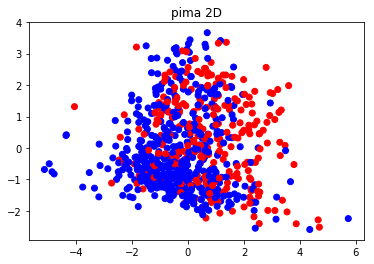

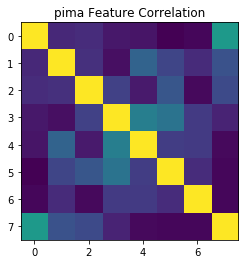

In [6]:
plot.plot_data(X_pima,y_pima, 'pima')

## Plot Kernels

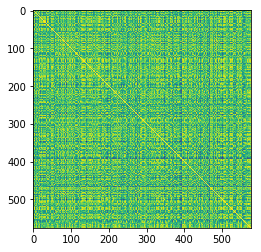

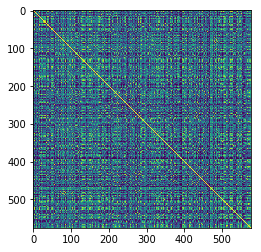

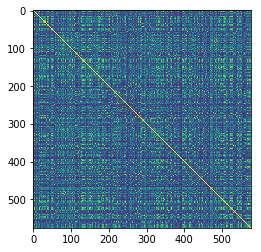

In [7]:
for i in range(3):
    plot.plot_kernel(K[i,...],'pima_k%d'%i)

# BEMKL

## Non-Sparse

In [8]:
### One time Evaluation 

reload(bemkl_binary)

nsp_clf = bemkl_binary.BEMKL(sparse=False)

t1 = time.time()

nsp_clf.bemkl_binary(K,y)

t2 = time.time()
diff = t2 - t1

pred, prob = nsp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.8072916666666666
Training Time: 14.1990330219


## Kernel-Sparse

In [9]:
sp_clf = bemkl_binary.BEMKL(sparse=True)

t1 = time.time()

sp_clf.bemkl_binary(K,y)


t2 = time.time()
diff = t2 - t1

pred, prob = sp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.78125
Training Time: 14.2716088295


In [10]:
sp_clf.report_results()

Nmber of Chosen Kernels:
20
Nmber of Chosen Points:
251


## data-sparse

In [11]:
dsp_clf = bemkl_binary.BEMKL(data_sparse=True)

t1 = time.time()

dsp_clf.bemkl_binary(K,y)


t2 = time.time()
diff = t2 - t1

pred, prob = dsp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff

Accuracy:
0.8020833333333334
Training Time: 13.9241940975


In [12]:
dsp_clf.report_results()

Nmber of Chosen Kernels:
59
Nmber of Chosen Points:
48


## Sparsity Plots

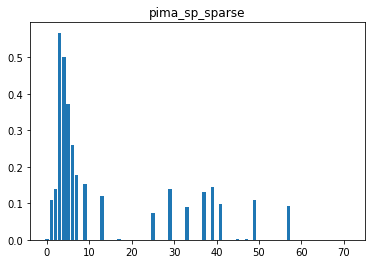

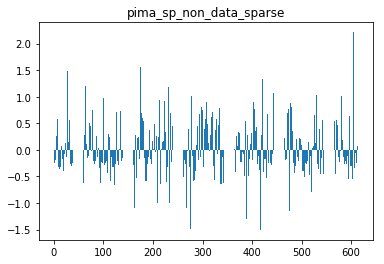

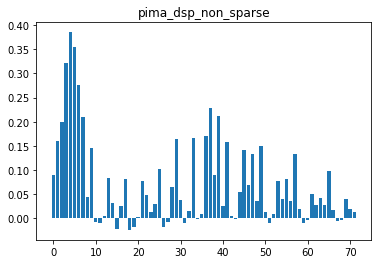

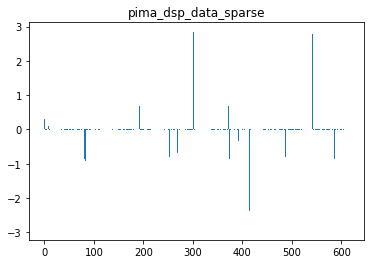

In [14]:
plot.plot_results(sp_clf, 'pima_sp')
plot.plot_results(dsp_clf, 'pima_dsp')


## Cross Validation

In [13]:
print 'Cross Validation Results for Non-Sparse model:'
nsp_clf = bemkl_binary.BEMKL(sparse=False)
nsp_clf.evaluate_model(K_pima,y_pima)

print 'Cross Validation Results for Kernel-Sparse model:'
sp_clf = bemkl_binary.BEMKL(sparse=True)
sp_clf.evaluate_model(K_pima,y_pima)

print 'Cross Validation Results for Data-Sparse model:'
dsp_clf = bemkl_binary.BEMKL(data_sparse=True)
dsp_clf.evaluate_model(K_pima,y_pima)

Cross Validation Results for Non-Sparse model:
Mean Accuracy: 0.7773703420762244
Cross Validation Results for Kernel-Sparse model:
Mean Accuracy: 0.7747644512350395
Cross Validation Results for Data-Sparse model:
Mean Accuracy: 0.7747644512350395


## data and kernel sparse

In [ ]:
'''all_sp_clf = bemkl_binary.BEMKL(data_sparse=True, sparse=True)

t1 = time.time()

all_sp_clf.bemkl_binary(K,y)


t2 = time.time()
diff = t2 - t1

pred, prob = all_sp_clf.predict(K_test)

print 'Accuracy:'
print (pred==y_test).sum()*1./y_test.shape[0]
print 'Training Time:', diff'''